# Library Recommender

## Import libraries and data

In [40]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
repo_url = "https://raw.githubusercontent.com/baertsch/MGT-502-ML-Project/main/"

# Load datasets
interactions_train_df = pd.read_csv(repo_url + "kaggle_data/interactions_train.csv")
interactions_train_df.rename(columns={"u": "user_id"}, inplace=True)
items_df = pd.read_csv(repo_url + "kaggle_data/items.csv")
sample_submission_df = pd.read_csv(repo_url + "kaggle_data/sample_submission.csv")

#Display
display(interactions_train_df.head())
display(items_df.head())
display(sample_submission_df.head())



,user_id,i,t
0,4456,8581,1.687541e+09
1,142,1964,1.679585e+09
2,362,3705,1.706872e+09
3,1809,11317,1.673533e+09
4,4384,1323,1.681402e+09


,Title,Author,ISBN Valid,Publisher,Subjects,i
0,Classification décimale universelle : édition ...,NaN,9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1
2,Histoire de vie et recherche biographique : pe...,NaN,2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4


,user_id,recommendation
0,0,3758 11248 9088 9895 5101 6074 9295 14050 1096...
1,1,3263 726 1589 14911 6432 10897 6484 7961 8249 ...
2,2,13508 9848 12244 2742 11120 2893 2461 5439 116...
3,3,2821 10734 6357 5934 2085 12608 12539 10551 10...
4,4,12425 219 11602 1487 14178 489 13888 2110 4413...


In [11]:
n_users = interactions_train_df['user_id'].nunique()
n_items = items_df['i'].nunique()
print(f"Number of users: {n_users}")
print(f"Number of items: {n_items}")
print(f"Number of books in the library: {items_df['i'].nunique()}")
print(sample_submission_df.nunique())

Number of users: 7838
Number of items: 15291
Number of books in the library: 15291
user_id           7838
recommendation    7838
dtype: int64


It looks like there are __7838__ users and __15291__ books in the library.

# Split the data

In [8]:
# Sort the interactions_train_df by 'user_id' and 'timestamp'
interactions_train_df.sort_values(by=['user_id', 't'], inplace=True)
interactions_train_df['pct_rank'] = interactions_train_df.groupby('user_id')['t'].rank(pct=True, method='dense')
interactions_train_df.reset_index(drop=True, inplace=True)
interactions_train_df.head(10)

,user_id,i,t,pct_rank
0,0,0,1.680191e+09,0.04
1,0,1,1.680783e+09,0.08
2,0,2,1.680801e+09,0.12
3,0,3,1.683715e+09,0.16
4,0,3,1.683715e+09,0.20
5,0,4,1.686569e+09,0.24
6,0,5,1.687014e+09,0.28
7,0,6,1.687014e+09,0.32
8,0,7,1.687014e+09,0.36
9,0,8,1.687260e+09,0.40


In [9]:
train_data = interactions_train_df[interactions_train_df['pct_rank'] <= 0.8]
test_data = interactions_train_df[interactions_train_df['pct_rank'] > 0.8]
print("Training set size:", train_data.shape[0])
print("Test set size:", test_data.shape[0])

Training set size: 66577
Test set size: 20470


In [23]:
print(train_data[['user_id','i']].duplicated().sum())
print(test_data[['user_id','i']].duplicated().sum())

16055
2044


It seems that the some users have interacted with some items more than once.

# First model

We are going to build first a model which treats doesn't account for the frequency a user has interacted with an item.

## Create User-Item Matrices

In [24]:
def create_data_matrix1(data, n_users, n_items):
    """
    This function creates a data matrix with binary values for the interactions, 1 is interaction and 0 is no interaction.
    The data matrix is of shape (n_users, n_items). 
    """
    data_matrix = np.zeros((n_users, n_items))
    data_matrix[data['user_id'].values, data['i'].values] = 1
    return data_matrix

In [25]:
train_data_matrix = create_data_matrix1(train_data, n_users, n_items)
test_data_matrix = create_data_matrix1(test_data, n_users, n_items)

# Display the matrices
print("Training data matrix")
print(train_data_matrix)
print("Number of interactions: ", np.sum(train_data_matrix))
print("Testing data matrix")
print(test_data_matrix)
print("Number of interactions: ", np.sum(test_data_matrix))

Training data matrix
[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Number of interactions:  50522.0
Testing data matrix
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Number of interactions:  18426.0


## Visualization of the matrices for a small portion of the data

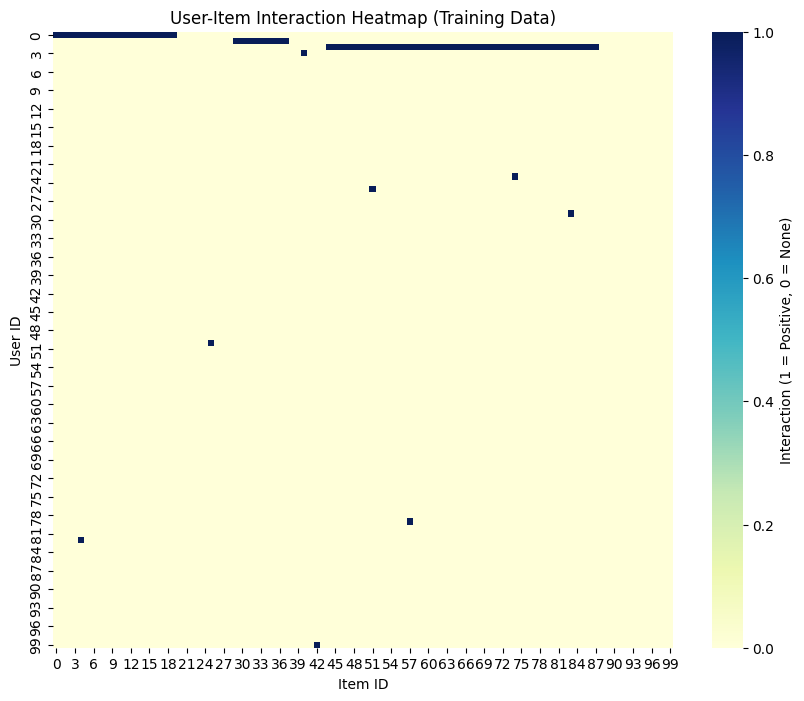

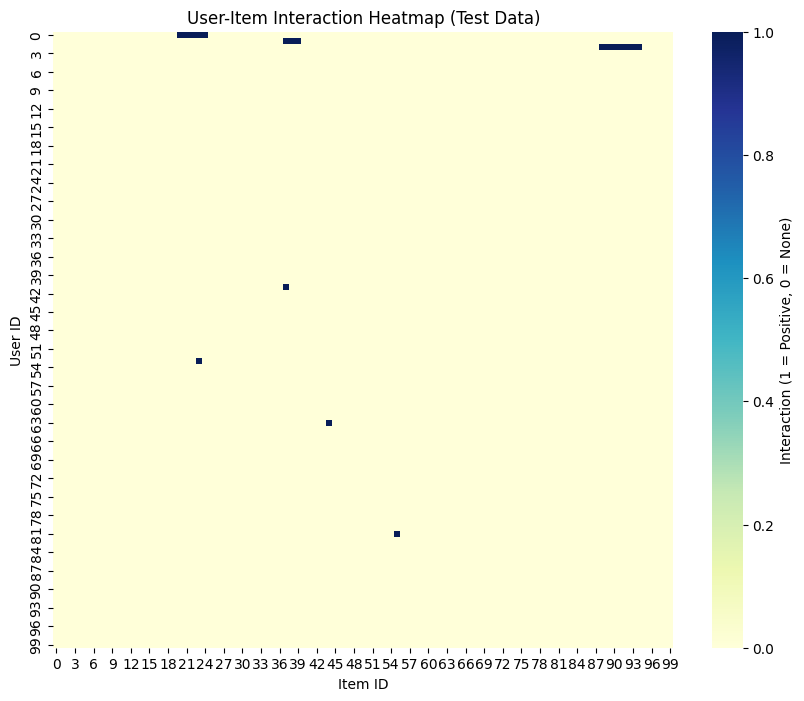

In [49]:
def plot_interaction_heatmap1(data_matrix, n_users=50,n_items=50, title="Interaction Heatmap"):
    """
    This function plots a heatmap of the interaction data matrix.
    """
    matrix_subset = data_matrix[:n_users, :n_items]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap='YlGnBu', cbar=True,cbar_kws={'label': 'Interaction (1 = Positive, 0 = None)'})
    plt.title(title)
    plt.xlabel('Item ID')
    plt.ylabel('User ID')
    plt.show()

plot_interaction_heatmap1(train_data_matrix, n_users=100, n_items=100, title="User-Item Interaction Heatmap (Training Data)")
plot_interaction_heatmap1(test_data_matrix, n_users=100, n_items=100, title="User-Item Interaction Heatmap (Test Data)")

## Item-to-Item Implicit Feedback

In [54]:
item_similarity = cosine_similarity(train_data_matrix.T)
print(item_similarity)
print("Item similarity shape:", item_similarity.shape)

[[1.         0.40824829 0.33333333 ... 0.         0.         0.        ]
 [0.40824829 1.         0.40824829 ... 0.         0.         0.        ]
 [0.33333333 0.40824829 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]
Item similarity shape: (15291, 15291)


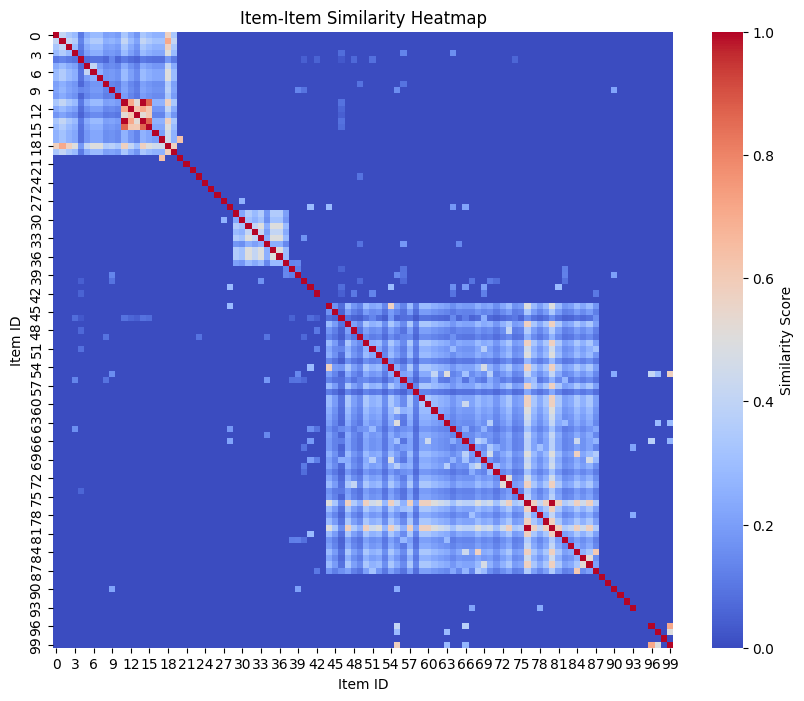

In [55]:
# Let's visualize the item similarity matrix
def plot_item_similarity_heatmap(matrix, n_items=50, title="Item Similarity Heatmap"):
    """
    This function plots a heatmap of the item similarity matrix.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix[:n_items, :n_items], cmap='coolwarm', cbar=True,cbar_kws={'label': 'Similarity Score'})
    plt.title(title)
    plt.xlabel('Item ID')
    plt.ylabel('Item ID')
    plt.show()
plot_item_similarity_heatmap(item_similarity, n_items=100, title="Item-Item Similarity Heatmap")

Let's look at the clusters of high similarity 

In [58]:
items_df[(items_df['i']>=11) & (items_df['i']<=15)]

,Title,Author,ISBN Valid,Publisher,Subjects,i
11,Rendre les élèves acteurs de leurs apprentissa...,"Béal, Yves",9782206013725; 220601372X,Delagrave,apprentissage (psychologie)--enfant; apprentis...,11
12,L'apprentissage par projets au secondaire : gu...,"Larmer, John",9782765033202; 276503320X,Chenelière éducation,apprentissage (psychologie)--enseignement seco...,12
13,Pour une pédagogie du projet /,"Bordalo, Isabelle",9782011709219; 2011709210,Hachette éducation,Enseignement--Méthode des projets,13
14,Une classe qui coopère : pourquoi ? comment ? /,"Staquet, Christian",9782850084324; 2850084328,Chronique sociale,apprentissage (psychologie)--classe (enseignem...,14
15,Penser le projet : concepts et outils d'une pé...,"Tilman, Francis",2850085510; 9782850085512,Chronique sociale,pédagogie de la maîtrise,15


In [60]:
items_df[(items_df['i']>=0) & (items_df['i']<=19)][['Title','Subjects']]

,Title,Subjects
0,Classification décimale universelle : édition ...,Classification décimale universelle; Indexatio...
1,Les interactions dans l'enseignement des langu...,didactique--langue étrangère - enseignement; d...
2,Histoire de vie et recherche biographique : pe...,Histoires de vie en sociologie; Sciences socia...
3,Ce livre devrait me permettre de résoudre le c...,Moyen-Orient; Bandes dessinées autobiographiqu...
4,Les années glorieuses : roman /,France--1945-1975; Roman historique; Roman fra...
5,100 idées pour mieux gérer les troubles de l'a...,Trouble déficitaire de l'attention avec ou san...
6,La boîte à outils des formateurs : 71 outils...,Formateurs (éducation des adultes)--Formation...
7,L'autorité éducative dans la classe : douze si...,autorité--relation maître-élève; autorité--ens...
8,Un autre regard sur le climat /,Climat--Détérioration; Bandes dessinées
9,Le mirage de la croissance verte /,Développement économique--Aspect environnement...


## Predict interactions using item similarity

In [63]:
def item_based_predict(matrix, similarity, epsilon = 1e-9):
    """
    This function predicts user-item interactions based on item similarity.
    Parameters:
    - matrix: The user-item interaction matrix.
    - similarity: The item-item similarity matrix.
    - epsilon: A small value to avoid division by zero.
    Returns:
    - numpy array of likelihood of interactions for each user-item pair.
    """
    pred = similarity.dot(matrix.T) / (similarity.sum(axis=1)[:, np.newaxis] + epsilon)
    return pred.T

item_based_predictions = item_based_predict(train_data_matrix, item_similarity)
print("Predicted Interactrion Matrix using Item-to-Item Similarity")
print(item_based_predictions)
print("Predicted Interaction Matrix shape:", item_based_predictions.shape)

Predicted Interactrion Matrix using Item-to-Item Similarity
[[0.47610083 0.86088344 0.70208194 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Predicted Interaction Matrix shape: (7838, 15291)


# Second model

This one accounts the number of times the user has interacted with the item. So in the formula:

\begin{equation}
{p}_{u}(i) =  \frac{\sum\limits_{i' \in I} \text{sim}(i, i') \cdot {R}_{u}(i')}{\sum\limits_{i' \in I} \text{sim}(i, i')}
\end{equation}

$R_u(i')$ is the number of times user u interacted with item i'

In [37]:
def create_data_matrix2(data, n_users, n_items):
    """
    This function creates a data matrix with frequency values for the interactions. 
    The matrix is of shape (n_users, n_items) where each value represents the frequency of interaction.
    """
    # Initialize a matrix of zeros, where rows represent users and columns represent items
    data_matrix = np.zeros((n_users, n_items))
    
    # Add the frequency of interactions between users and items
    for _, row in data.iterrows():
        user_id = int(row['user_id'])
        item_id = int(row['i'])
        data_matrix[user_id, item_id] += 1  # Increment the count for each interaction
    
    return data_matrix

In [38]:
train_data_matrix2 = create_data_matrix2(train_data, n_users, n_items)
test_data_matrix2 = create_data_matrix2(test_data, n_users, n_items)
# Display the matrices
print("Training data matrix")
print(train_data_matrix2)
print("Number of interactions: ", np.sum(train_data_matrix2))
print("Testing data matrix")
print(test_data_matrix2)
print("Number of interactions: ", np.sum(test_data_matrix2))

Training data matrix
[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Number of interactions:  66577.0
Testing data matrix
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Number of interactions:  20470.0


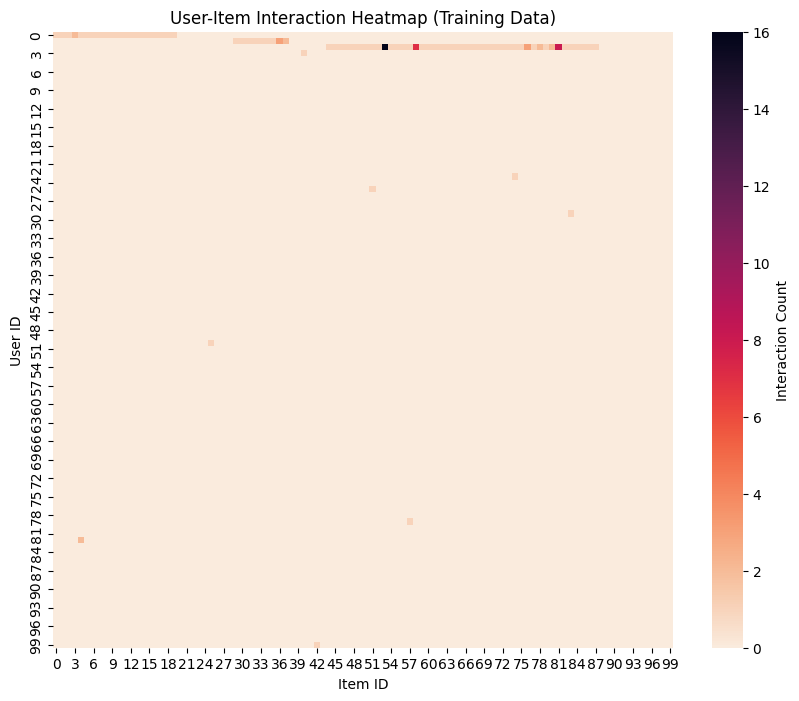

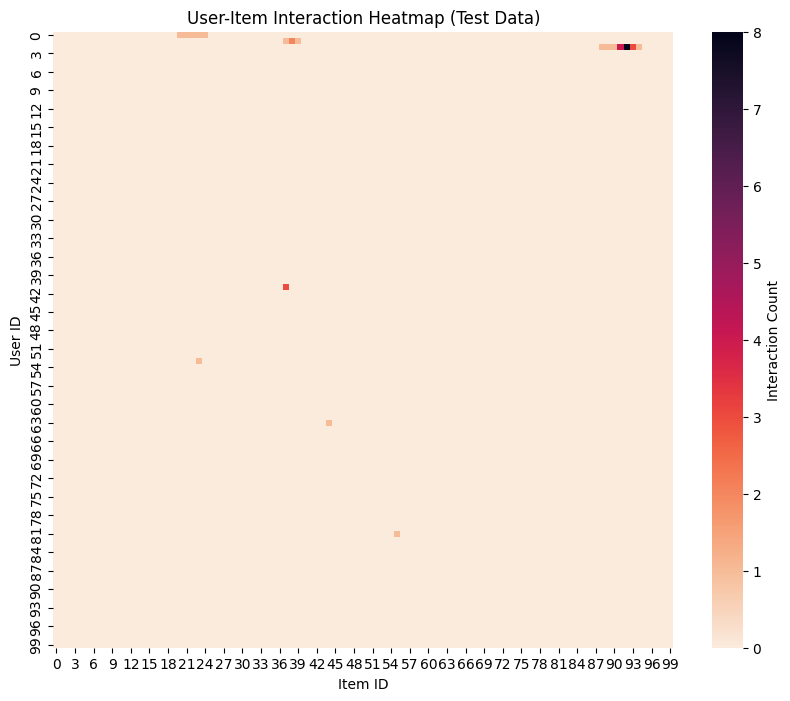

In [53]:
def plot_interaction_heatmap2(data_matrix, n_users=100,n_items=100, title="Interaction Heatmap"):
    """
    This function plots a heatmap of the interaction data matrix.
    """
    matrix_subset = data_matrix[:n_users, :n_items]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap='rocket_r', cbar=True,cbar_kws={'label': 'Interaction Count'})
    plt.title(title)
    plt.xlabel('Item ID')
    plt.ylabel('User ID')
    plt.show()

plot_interaction_heatmap2(train_data_matrix2, n_users=100, n_items=100, title="User-Item Interaction Heatmap (Training Data)")
plot_interaction_heatmap2(test_data_matrix2, n_users=100, n_items=100, title="User-Item Interaction Heatmap (Test Data)")